In [2]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from math import sqrt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

2024-03-05 19:02:44.001702: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

In [ ]:


batch_size = 32  # This is the number of samples per gradient update.
time_steps = 100  # This is the 'window' of time steps you're looking at to predict the next step.
features = 1  # For univariate data, the number of features is 1.

model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, stateful=True, batch_input_shape=(batch_size, time_steps, features)),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=True, stateful=True),
    Dropout(0.2),
    LSTM(50, activation='relu', stateful=True),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


# USDC Univariate LSTM Time Series

Approximately 2,000 samples

In [4]:
def json_to_prices(json):
    df = pd.read_json(json)
    prices = df['prices']
    coin_prices = pd.DataFrame(prices.tolist(), columns=['time', 'price'])
    prices = coin_prices['price']
    return prices

In [115]:
prices = json_to_prices('usdc90days.json')

In [5]:
def normalize_prices(prices):
    normalized_prices = (prices - np.mean(prices)) / np.std(prices)
    return normalized_prices

In [117]:
# Normalize the prices data
normalized_prices = (prices - np.mean(prices)) / np.std(prices)
print(normalized_prices)

0       0.313974
1      -0.139964
2      -0.707387
3      -0.026480
4      -1.274809
          ...   
2155   -2.977077
2156   -0.026480
2157    0.540943
2158   -1.501778
2159    0.087005
Name: price, Length: 2160, dtype: float64


In [6]:
def split_data(normalized_prices, split=0.8):
    train_size = int(len(normalized_prices) * split)
    test_size = len(normalized_prices) - train_size
    
    training_data = normalized_prices[0:train_size]
    test_data = normalized_prices[train_size:len(normalized_prices)]
    return training_data, test_data

    # X_train, X_test = X[0:train_size], X[train_size:len(X)]
    # y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [7]:
def create_dataset_helper(data, time_step=1):
    X, y = [], []
    data = data.reset_index(drop=True)

    for i in range(len(data) - time_step):      
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

In [8]:
def create_dataset(data, time_steps=1):
    X, y = create_dataset_helper(data, time_steps)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return X, y

In [121]:
print(test_data)

1728    0.427458
1729   -0.366933
1730   -0.253449
1731   -0.253449
1732    0.313974
          ...   
2155   -2.977077
2156   -0.026480
2157    0.540943
2158   -1.501778
2159    0.087005
Name: price, Length: 432, dtype: float64


In [122]:
time_step = 10 # This is the number of time steps you're looking at to predict the next step.

# Split the data into training and testing data
training_data, test_data = split_data(normalized_prices)
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [124]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1718, 10, 1) (1718,) (422, 10, 1) (422,)


In [127]:
train_size = X_train.shape[0]
test_size = X_test.shape[0]
print(train_size, test_size)

1718 422


In [9]:
def create_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [129]:
model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [130]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
54/54 [==============================] - 3s 6ms/step - loss: 0.9172
Epoch 2/50
54/54 [==============================] - 0s 6ms/step - loss: 0.9115
Epoch 3/50
54/54 [==============================] - 0s 6ms/step - loss: 0.9112
Epoch 4/50
54/54 [==============================] - 0s 6ms/step - loss: 0.9103
Epoch 5/50
54/54 [==============================] - 0s 6ms/step - loss: 0.9101
Epoch 6/50
54/54 [==============================] - 0s 6ms/step - loss: 0.9110
Epoch 7/50
54/54 [==============================] - 0s 6ms/step - loss: 0.9097
Epoch 8/50
54/54 [==============================] - 0s 8ms/step - loss: 0.9083
Epoch 9/50
54/54 [==============================] - 0s 6ms/step - loss: 0.9067
Epoch 10/50
54/54 [==============================] - 0s 6ms/step - loss: 0.9109
Epoch 11/50
54/54 [==============================] - 0s 6ms/step - loss: 0.9065
Epoch 12/50
54/54 [==============================] - 0s 6ms/step - loss: 0.9081
Epoch 13/50
54/54 [==============================

In [10]:
def predictions(model, X_train, y_train, X_test, y_test, prices):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_predict = (train_predictions * np.std(prices)) + np.mean(prices)
    y_train = (y_train * np.std(prices)) + np.mean(prices)
    test_predict = (test_predictions * np.std(prices)) + np.mean(prices)
    y_test = (y_test * np.std(prices)) + np.mean(prices)
    
    train_score = sqrt(mean_squared_error(y_train, train_predict))
    print('Train Score: %.20f RMSE' % (train_score))
    test_score = sqrt(mean_squared_error(y_test, test_predict))
    print('Test Score: %.20f RMSE' % (test_score))
    return train_predict, test_predict
    

In [143]:
train_predict, test_predict = predictions(model, X_train, y_train, X_test, y_test, prices)

14/14 [==============================] - 0s 3ms/step
Train Score: 0.00080894037840187631 RMSE
Test Score: 0.00106814382564748931 RMSE


In [139]:
print(test_predict.shape)

(422, 1)


In [140]:
train_predict_flattened = train_predict.flatten()
test_predict_flattened = test_predict.flatten()

(422,)


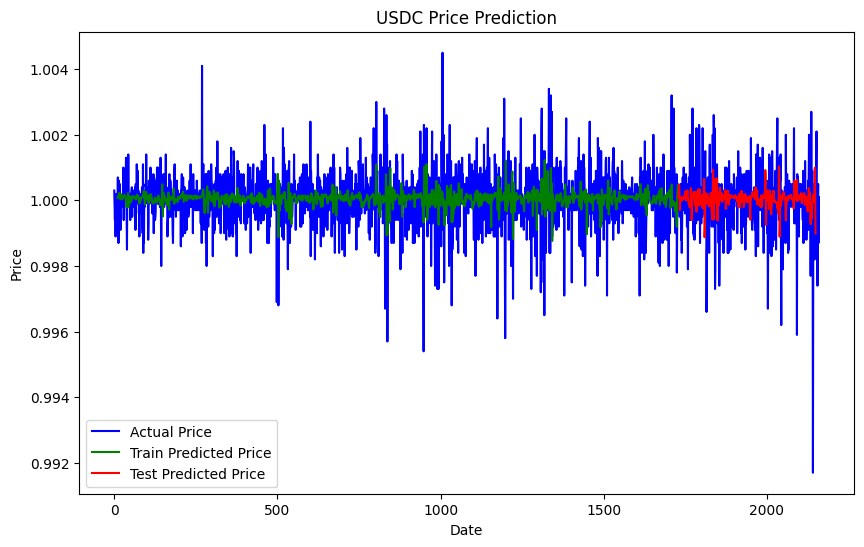

In [141]:
# graph the results

# reshape train_predict and test_predict to the shape of prices

plt.figure(figsize=(10, 6))
plt.plot(prices, color='blue', label='Actual Price')
plt.plot(range(time_step, train_size + time_step), train_predict_flattened, color='green', label='Train Predicted Price')
plt.plot(range(train_size + time_step, train_size + time_step + test_size), test_predict_flattened, color='red', label='Test Predicted Price')

plt.title('USDC Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Ethereum Univariate LSTM Time Series

In [11]:
time_step = 10

prices = json_to_prices('usdc90days.json')
normalized_prices = normalize_prices(prices)
training_data, test_data = split_data(normalized_prices)
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
lstm = create_model()

lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))


Epoch 1/100
54/54 [==============================] - 4s 19ms/step - loss: 0.9179 - val_loss: 1.3897
Epoch 2/100
54/54 [==============================] - 0s 7ms/step - loss: 0.9129 - val_loss: 1.3886
Epoch 3/100
54/54 [==============================] - 0s 7ms/step - loss: 0.9136 - val_loss: 1.3908
Epoch 4/100
54/54 [==============================] - 0s 7ms/step - loss: 0.9118 - val_loss: 1.3861
Epoch 5/100
54/54 [==============================] - 0s 7ms/step - loss: 0.9106 - val_loss: 1.3875
Epoch 6/100
54/54 [==============================] - 0s 8ms/step - loss: 0.9106 - val_loss: 1.3834
Epoch 7/100
54/54 [==============================] - 0s 7ms/step - loss: 0.9088 - val_loss: 1.3855
Epoch 8/100
54/54 [==============================] - 0s 7ms/step - loss: 0.9093 - val_loss: 1.3925
Epoch 9/100
54/54 [==============================] - 0s 8ms/step - loss: 0.9102 - val_loss: 1.3872
Epoch 10/100
54/54 [==============================] - 0s 7ms/step - loss: 0.9085 - val_loss: 1.3871
Epoch 11

In [12]:
predictions(lstm, X_train, y_train, X_test, y_test, prices)

14/14 [==============================] - 0s 2ms/step
Train Score: 0.00052674990770718163 RMSE
Test Score: 0.00125192868642671758 RMSE


(array([[1.0002184],
        [0.9998289],
        [0.9997923],
        ...,
        [1.0000703],
        [1.0003362],
        [1.0003027]], dtype=float32),
 array([[1.0003036 ],
        [0.99987245],
        [1.000243  ],
        [1.0004522 ],
        [1.000552  ],
        [1.0009731 ],
        [0.9999864 ],
        [0.9999348 ],
        [0.9996154 ],
        [0.9997267 ],
        [0.9992924 ],
        [0.99979985],
        [0.99921614],
        [0.99998343],
        [0.99990666],
        [1.0002623 ],
        [0.99979866],
        [0.99984723],
        [1.00023   ],
        [0.9999719 ],
        [1.0000643 ],
        [1.0005682 ],
        [1.0000248 ],
        [0.99980175],
        [0.99946725],
        [1.0000734 ],
        [0.99968773],
        [1.0001581 ],
        [1.0004892 ],
        [1.0002381 ],
        [0.9998982 ],
        [1.0005642 ],
        [1.0004225 ],
        [1.0005865 ],
        [0.99958295],
        [0.99891543],
        [0.99968684],
        [0.99978995],
        

# DAI Univariate LSTM Time Series

In [14]:
time_step = 10

prices = json_to_prices('dai90days.json')
normalized_prices = normalize_prices(prices)
training_data, test_data = split_data(normalized_prices)
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
lstm = create_model()

lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
54/54 [==============================] - 4s 20ms/step - loss: 0.8694 - val_loss: 1.1332
Epoch 2/50
54/54 [==============================] - 0s 7ms/step - loss: 0.8443 - val_loss: 1.1121
Epoch 3/50
54/54 [==============================] - 0s 7ms/step - loss: 0.8326 - val_loss: 1.1185
Epoch 4/50
54/54 [==============================] - 0s 7ms/step - loss: 0.8227 - val_loss: 1.1330
Epoch 5/50
54/54 [==============================] - 0s 7ms/step - loss: 0.8137 - val_loss: 1.1278
Epoch 6/50
54/54 [==============================] - 0s 7ms/step - loss: 0.8042 - val_loss: 1.1338
Epoch 7/50
54/54 [==============================] - 0s 7ms/step - loss: 0.8018 - val_loss: 1.1518
Epoch 8/50
54/54 [==============================] - 0s 7ms/step - loss: 0.7950 - val_loss: 1.1659
Epoch 9/50
54/54 [==============================] - 0s 8ms/step - loss: 0.7977 - val_loss: 1.1670
Epoch 10/50
54/54 [==============================] - 0s 7ms/step - loss: 0.7959 - val_loss: 1.1738
Epoch 11/50
54/54 

In [15]:
predictions(lstm, X_train, y_train, X_test, y_test, prices)

14/14 [==============================] - 0s 4ms/step
Train Score: 0.00102208565685368694 RMSE
Test Score: 0.00143763647894762283 RMSE


(array([[0.998244  ],
        [0.99809456],
        [0.9981376 ],
        ...,
        [0.9995385 ],
        [0.9994799 ],
        [0.99941075]], dtype=float32),
 array([[0.9996675 ],
        [0.99984246],
        [0.999565  ],
        [0.99993664],
        [0.9998579 ],
        [0.99961   ],
        [0.9999547 ],
        [0.9998314 ],
        [0.9997874 ],
        [0.99961704],
        [0.9997485 ],
        [0.9997332 ],
        [1.0000385 ],
        [0.99947923],
        [0.9997459 ],
        [1.000243  ],
        [0.9995077 ],
        [0.9991618 ],
        [1.0001595 ],
        [1.0000381 ],
        [0.9999559 ],
        [0.9999561 ],
        [0.9996035 ],
        [1.0000774 ],
        [1.000021  ],
        [0.9997341 ],
        [1.0003717 ],
        [0.9998115 ],
        [0.99912316],
        [0.99943566],
        [0.99945307],
        [0.99950165],
        [0.9993519 ],
        [0.999385  ],
        [0.9992885 ],
        [0.99929225],
        [0.99946713],
        [0.9995996 ],
  

# USDT Univariate LSTM Time Series

In [16]:
time_step = 10

prices = json_to_prices('usdt90days.json')
normalized_prices = normalize_prices(prices)
training_data, test_data = split_data(normalized_prices)
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
lstm = create_model()

lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
54/54 [==============================] - 4s 20ms/step - loss: 0.7047 - val_loss: 1.2838
Epoch 2/50
54/54 [==============================] - 0s 7ms/step - loss: 0.6688 - val_loss: 1.2675
Epoch 3/50
54/54 [==============================] - 0s 7ms/step - loss: 0.6666 - val_loss: 1.2656
Epoch 4/50
54/54 [==============================] - 0s 7ms/step - loss: 0.6634 - val_loss: 1.2691
Epoch 5/50
54/54 [==============================] - 0s 9ms/step - loss: 0.6626 - val_loss: 1.2694
Epoch 6/50
54/54 [==============================] - 0s 7ms/step - loss: 0.6623 - val_loss: 1.2700
Epoch 7/50
54/54 [==============================] - 0s 8ms/step - loss: 0.6625 - val_loss: 1.2581
Epoch 8/50
54/54 [==============================] - 0s 8ms/step - loss: 0.6574 - val_loss: 1.2681
Epoch 9/50
54/54 [==============================] - 0s 8ms/step - loss: 0.6591 - val_loss: 1.2609
Epoch 10/50
54/54 [==============================] - 0s 8ms/step - loss: 0.6609 - val_loss: 1.2544
Epoch 11/50
54/54 

In [17]:
predictions(lstm, X_train, y_train, X_test, y_test, prices)

14/14 [==============================] - 0s 3ms/step
Train Score: 0.00076653169336079509 RMSE
Test Score: 0.00111029582797143801 RMSE


(array([[1.0002548],
        [1.0001608],
        [1.000115 ],
        ...,
        [1.0002732],
        [1.000302 ],
        [1.0002693]], dtype=float32),
 array([[1.0003809 ],
        [1.0003153 ],
        [1.0004542 ],
        [1.0004015 ],
        [1.0003313 ],
        [1.0003446 ],
        [1.0003169 ],
        [1.0002354 ],
        [1.0002362 ],
        [1.0001503 ],
        [1.0002325 ],
        [1.0002501 ],
        [1.0001863 ],
        [1.0002044 ],
        [1.0001067 ],
        [1.0000522 ],
        [0.9999922 ],
        [0.9999836 ],
        [1.0001583 ],
        [1.0000905 ],
        [1.0001135 ],
        [1.0000889 ],
        [1.0001906 ],
        [1.0001696 ],
        [1.0002745 ],
        [1.0002389 ],
        [1.0002033 ],
        [1.0001731 ],
        [1.0001197 ],
        [1.0001479 ],
        [1.0001013 ],
        [1.000178  ],
        [1.0001377 ],
        [1.0002499 ],
        [1.0001358 ],
        [1.0001477 ],
        [1.0001373 ],
        [1.0002141 ],
        